# PEC3: Machine Learning

## Cargar Librerías

In [24]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_colwidth', None)
sns.set(color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


import warnings
warnings.filterwarnings('ignore')

## Cargar datos
Tras la recopilación y unificación de los datos en la PEC1 y PEC2, partimos de un DataFrame inicial (df_unificado) que contenía 21.186 registros y 43 columnas, dicho dataset incluía todo tipo de información relacionada con propiedades inmobiliarias, como el tipo de vivienda, el precio, la superficie, la localización o el estado de conservación. No obstante, una primera exploración nos indicó la existencia de valores nulos en múltiples columnas, como latitude, longitude, parkingSpace, labels o externalReference, además de columnas redundantes como Unnamed: 0 o index. Algunas de estas variables las eliminamos por carecer de utilidad, mientras que otras las conservamos(por su posible valor informativo).

In [25]:
df = pd.read_csv("df_limpio.csv")
df.head()
print("Forma del DataFrame:", df.shape)
df.info()
df.describe()
df.isnull().sum()


Forma del DataFrame: (13272, 37)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13272 entries, 0 to 13271
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   propertyCode            13272 non-null  int64  
 1   thumbnail               13239 non-null  object 
 2   externalReference       11855 non-null  object 
 3   numPhotos               13272 non-null  float64
 4   floor                   11293 non-null  object 
 5   price                   13272 non-null  float64
 6   propertyType            13272 non-null  object 
 7   size                    13272 non-null  float64
 8   exterior                13272 non-null  bool   
 9   rooms                   13272 non-null  float64
 10  bathrooms               13272 non-null  float64
 11  address                 13272 non-null  object 
 12  province                13272 non-null  object 
 13  municipality            13272 non-null  object 
 14  distr

propertyCode                  0
thumbnail                    33
externalReference          1417
numPhotos                     0
floor                      1979
price                         0
propertyType                  0
size                          0
exterior                      0
rooms                         0
bathrooms                     0
address                       0
province                      0
municipality                  0
district                    996
country                       0
neighborhood               3447
latitude                      0
longitude                     0
showAddress                   0
url                           0
distance                      0
description                  31
hasVideo                      0
status                        0
newDevelopment                0
hasLift                       0
priceByArea                   0
detailedType                  0
suggestedTexts                0
hasPlan                       0
has3DTou

## Análisis Exploratorio de los Datos (EDA)

In [26]:
sns.set(style="whitegrid")

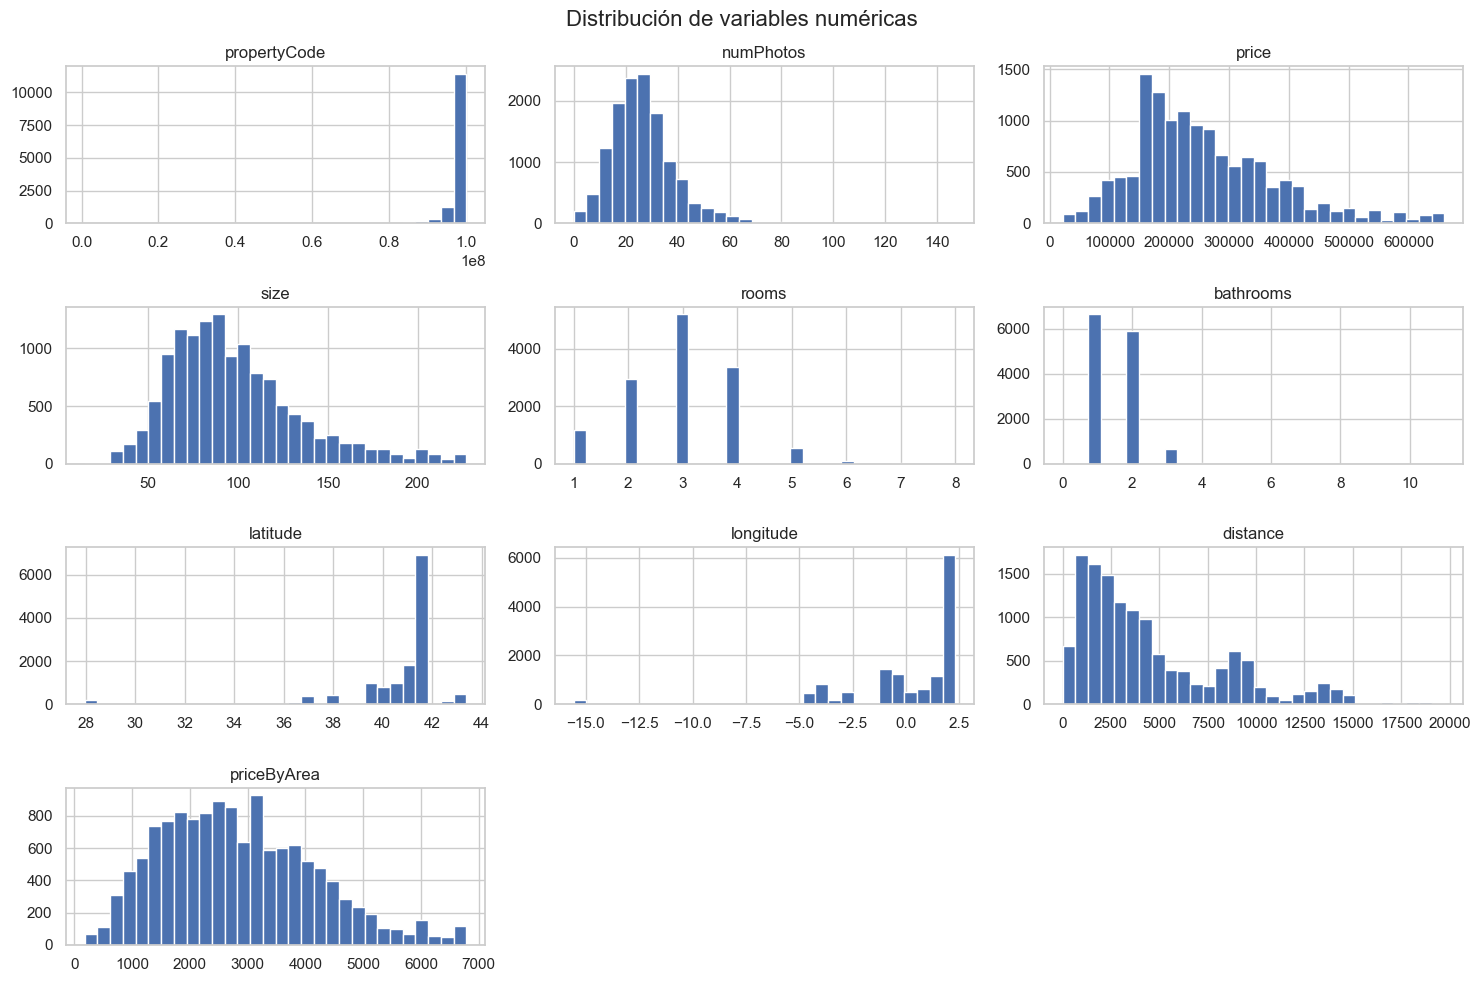

In [27]:
# Distribución de las variables numéricas
df.select_dtypes(include=['float64', 'int64']).hist(bins=30, figsize=(15,10))
plt.suptitle("Distribución de variables numéricas", fontsize=16)
plt.tight_layout()
plt.show()

Para explorar la distribución de las variables numéricas del conjunto de datos, presentamos histogramas para las siguientes variables: numPhotos, price, size, rooms, bathrooms, latitude, longitude, distance y priceByArea, de esta manera podremos detectar posibles sesgos o asimetrías.

Observamos que las variables como "price", "distance" y "priceByArea" presentan una distribución asimétrica positiva, con valores concentrados en los rangos bajos y una cola hacia la derecha. Por otra parte, "size" tiene una distribución relativamente más simétrica pero también muestra una ligera asimetría positiva. Después, "rooms" y "bathrooms" presentan valores discretos, siendo 3 habitaciones y 2 baños las configuraciones más frecuentes. Por último, "latitude" y "longitude" reflejan una concentración geográfica clara, asociada probablemente a las zonas más representadas en los datos.

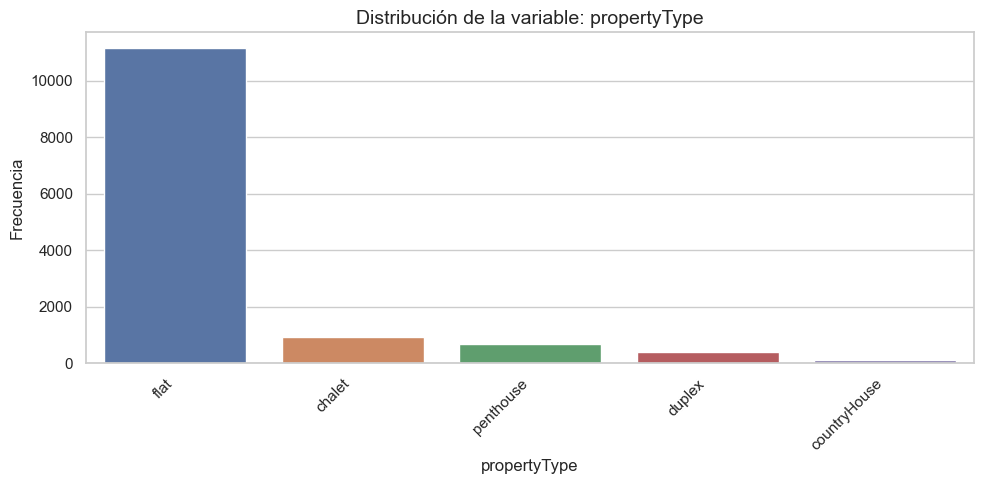

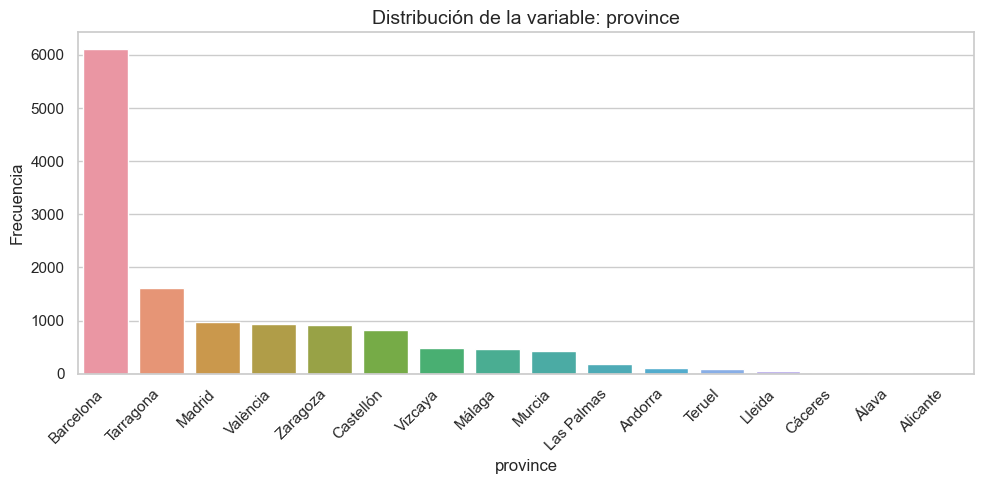

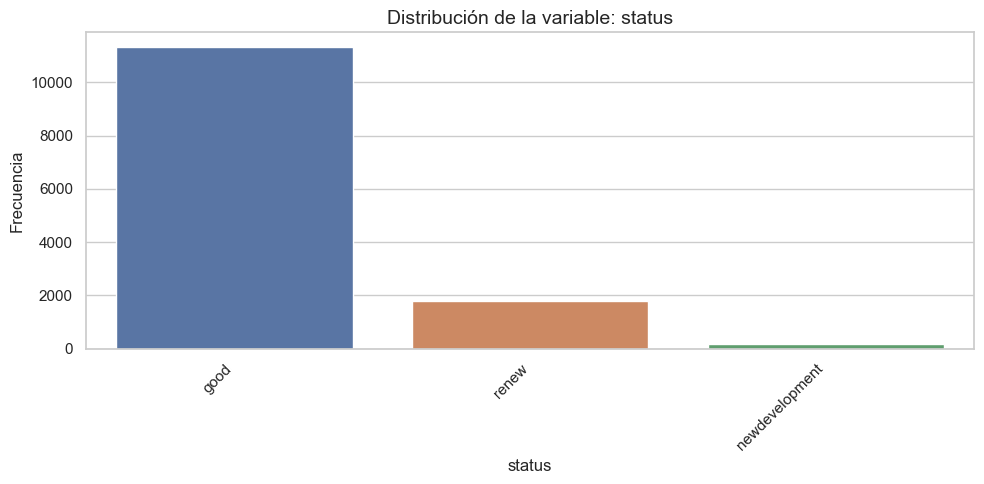

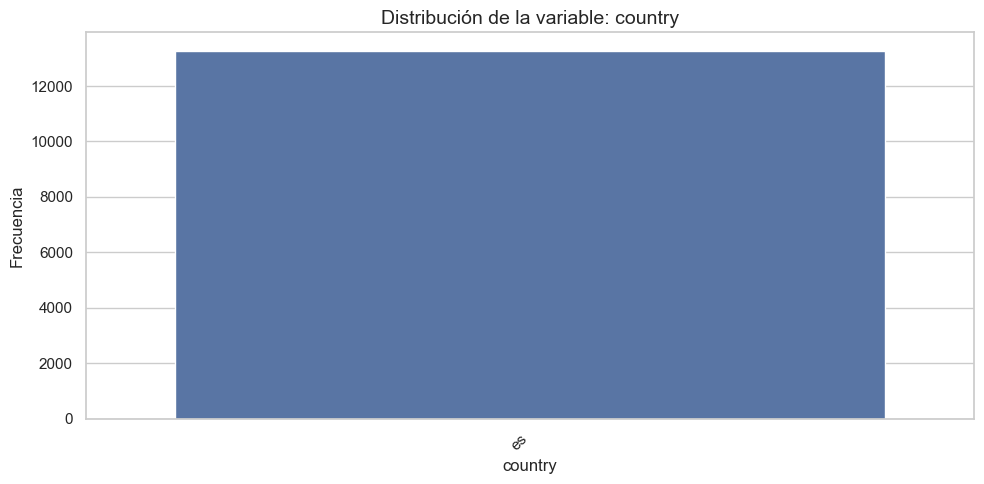

In [28]:
#Distribución de las variables categóricas
variables_categoricas = ['propertyType', 'province', 'status', 'country']

for var in variables_categoricas:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=var, order=df[var].value_counts().index)
    plt.title(f'Distribución de la variable: {var}', fontsize=14)
    plt.xlabel(var)
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

En este caso, hemos procedido a examinar las principales variables categóricas: propertyType, province, status y country, mediante gráficos de barras que muestran la frecuencia de cada categoría. Podemos indicar que "propertyType" está dominado por el tipo flat, con una presencia mucho mayor respecto al resto de tipos como chalet, penthouse, duplex y countryHouse. Por otra parte, "province" presenta un fuerte predominio de la provincia de Barcelona, seguida a distancia por Tarragona, Madrid, Valencia y otras. Después, "status" muestra que la gran mayoría de propiedades están en estado good, con menos propiedades en renew o newdevelopment. Finalmente, country contiene un único valor (es), lo cual indica que todos los inmuebles del dataset están ubicados en España.

Este análisis pone de manifiesto un desequilibrio en algunas categorías, lo que será importante tener en cuenta en fases posteriores de modelado o análisis comparativo.

## Preparación de los datos para el modelado.
Antes de aplicar modelos predictivos, es necesario que preparemos los datos adecuadamente. Este proceso incluye la eliminación de columnas irrelevantes, la conversión de variables categóricas en variables numéricas mediante dummies, el escalado de variables numéricas y la separación entre variables predictoras (X) y variable objetivo (y).

In [29]:
# 1. Eliminamos aquellas columnas que no aportan información útil al modelo predictivo, ya sea por ser identificadores únicos, enlaces o campos con valores redundantes o nulos en su mayoría.
columnas_a_eliminar = ['url', 'description', 'externalReference', 'thumbnail', 'suggestedTexts',
                        'hasVideo', 'hasPlan', 'has3DTour', 'has360', 'hasStaging']
df_modelado = df.drop(columns=columnas_a_eliminar)

# 2. Realizacmos una conversión de variables categóricas a dummies.
variables_dummies = ['propertyType', 'status', 'country']
df_modelado = pd.get_dummies(df_modelado, columns=variables_dummies, drop_first=True)

# 3. Procedemos a realizar un escalado de variables numéricas. Se aplica StandardScaler para escalar las variables numéricas a una media de 0 y desviación típica de 1.
from sklearn.preprocessing import StandardScaler

variables_a_escalar = ['price', 'size', 'priceByArea', 'numPhotos', 'rooms', 'bathrooms', 'distance']
scaler = StandardScaler()
df_modelado[variables_a_escalar] = scaler.fit_transform(df_modelado[variables_a_escalar])

# 4. Separamos el conjunto de variables independientes (X) de la variable objetivo (y), en este caso el price, para preparar los datos para el entrenamiento de modelos.
X = df_modelado.drop(columns=['price'])
y = df_modelado['price']

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (13272, 29)
y shape: (13272,)


# Pregunta 1: Aprendizaje No Supervisado (40 puntos)
Se pide crear un modelo KMEANS para clasificar las viviendas del conjunto de datos y representarlo gráficamente en el propio Notebook de Python. En este caso debéis tener en cuenta el número de clusters (k) que queréis que tenga vuestro modelo, podéis poner el que consideréis, pero se recomienda utilizar el llamado “elbow method” para estimarlo.

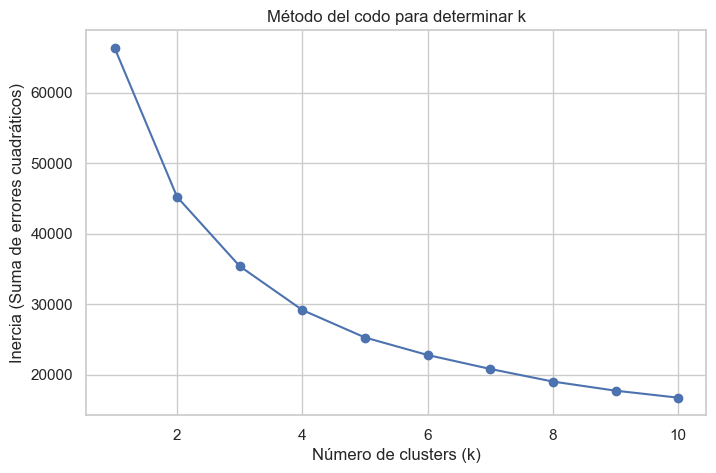

In [30]:
# Creamos una copia del DataFrame original para trabajar sobre ella
df_kmeans = df.copy()

# Seleccionamos solo las columnas numéricas que tengan sentido para el clustering
columnas_numericas = ['price', 'size', 'rooms', 'bathrooms', 'priceByArea']  # Puedes añadir más si lo crees necesario
X = df_kmeans[columnas_numericas]

# Escalamos estas variables numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicamos el método del codo para encontrar el número óptimo de clusters
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Mostramos el gráfico del método del codo
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (Suma de errores cuadráticos)')
plt.title('Método del codo para determinar k')
plt.grid(True)
plt.show()

In [31]:
# El codo se aprecia alrededor de k = 3 o 4. Por ello, entrenamos el modelo KMeans con k=3
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Añadimos la columna de clusters al DataFrame original
df_kmeans['cluster'] = clusters

# Mostramos las primeras filas con su cluster asignado
df_kmeans[['price', 'size', 'rooms', 'bathrooms', 'priceByArea', 'cluster']].head()


,price,size,rooms,bathrooms,priceByArea,cluster
0,285000.0,63.0,2.0,2.0,4524.0,1
1,178216.0,65.0,2.0,1.0,2742.0,1
2,333000.0,97.0,4.0,1.0,3433.0,2
3,481000.0,72.0,2.0,1.0,6681.0,2
4,291000.0,62.0,1.0,1.0,4694.0,1


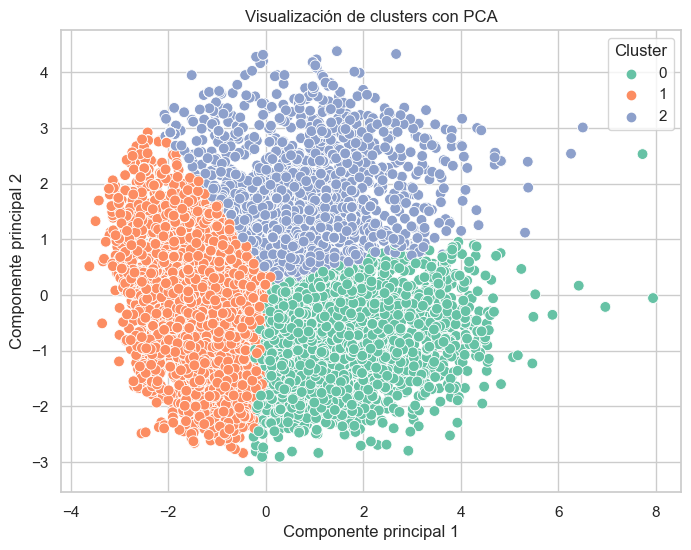

In [32]:
# Reducimos las dimensiones a 2D con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Creamos un DataFrame para visualizarlo
df_viz = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_viz['cluster'] = df_kmeans['cluster']

# Gráfico
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_viz, x='PCA1', y='PCA2', hue='cluster', palette='Set2', s=60)
plt.title('Visualización de clusters con PCA')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [33]:
# Asignamos las etiquetas de clúster al dataframe original modelado
df_modelado['cluster'] = kmeans.labels_

# Seleccionamos solo las columnas numéricas para el análisis por clúster
columnas_numericas = df_modelado.select_dtypes(include=['int64', 'float64']).columns

# Mostramos la media de cada variable numérica por clúster
cluster_description = df_modelado.groupby('cluster')[columnas_numericas].mean()
display(cluster_description)

# Mostramos el número de viviendas por clúster
cluster_counts = df_modelado['cluster'].value_counts().sort_index()
print("Cantidad de viviendas por clúster:")
print(cluster_counts)


,propertyCode,numPhotos,price,size,rooms,bathrooms,latitude,longitude,distance,priceByArea
cluster,,,,,,,,,,
0,9.773417e+07,0.264936,-0.367097,0.873740,0.509835,0.799267,39.986968,-0.621015,0.407851,-0.858818
1,9.823583e+07,-0.246339,-0.409236,-0.703821,-0.577967,-0.793544,40.917957,0.385476,-0.137532,0.142550
2,9.823823e+07,0.157185,1.415111,0.282148,0.528568,0.583811,41.180884,1.173045,-0.283837,0.917606


Cantidad de viviendas por clúster:
cluster
0    4120
1    6270
2    2882
Name: count, dtype: int64


Tras aplicar KMeans con k=3 y representar los datos en 2D usando PCA, hemos analizado las características promedio de cada grupo de viviendas.

- Clúster 0 (4.120 viviendas): Este grupo tiene valores de tamaño (`size`), número de habitaciones y precio por metro cuadrado (`priceByArea`) por encima de la media. Podría corresponderse con viviendas de mayor tamaño y calidad, posiblemente mejor ubicadas o con más prestaciones. Es un segmento atractivo del mercado.

- Clúster 1 (6.270 viviendas): Es el grupo más numeroso. Presenta valores negativos en la mayoría de las variables analizadas, como tamaño, habitaciones y precio por metro cuadrado. Esto sugiere que agrupa viviendas más pequeñas, económicas o con menos prestaciones. Podría representar pisos más modestos o antiguos.

- Clúster 2 (2.882 viviendas):  Aunque es el grupo más pequeño, destaca por tener una media de precio alta (`price` positivo) y valores positivos en `priceByArea`, con características intermedias en otras variables. Este segmento podría estar compuesto por viviendas en zonas céntricas o con alta demanda, donde el precio por metro cuadrado es elevado pese a no ser necesariamente grandes.

En conjunto, esta segmentación permite diferenciar tres perfiles de vivienda dentro del conjunto de datos: un grupo de viviendas grandes y caras, otro de viviendas económicas, y un tercero más equilibrado con precios altos por zona.



# Pregunta 2: Aprendizaje Supervisado – Regresión (30 puntos)
En esta sección se pide crear un modelo de regresión que permita predecir el precio de las viviendas a partir del resto de variables disponibles. Para ello, deberás entrenar un modelo supervisado y evaluar su rendimiento utilizando al menos una métrica de regresión adecuada (como MAE, RMSE o R²). Puedes utilizar el algoritmo de regresión que consideres más adecuado (como Regresión Lineal, Random Forest o XGBoost).

In [39]:
# Copiamos el dataframe limpio
df_regresion = df.copy()

# Eliminamos columnas irrelevantes para la predicción del precio
columnas_eliminar = [
    'propertyCode', 'thumbnail', 'url', 'externalReference', 'description',
    'detailedType', 'suggestedTexts', 'labels'
]
df_regresion.drop(columns=columnas_eliminar, inplace=True, errors='ignore')

# Eliminamos también columnas con muchos nulos
df_regresion.drop(columns=['parkingSpace', 'neighborhood'], inplace=True, errors='ignore')

# Eliminamos filas con nulos restantes
df_regresion.dropna(inplace=True)

# Codificamos variables categóricas
for col in df_regresion.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_regresion[col] = le.fit_transform(df_regresion[col])

# Variables predictoras y variable objetivo
X = df_regresion.drop("price", axis=1)
y = df_regresion["price"]

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento del modelo
modelo_lr = LinearRegression()
modelo_lr.fit(X_train, y_train)

# Predicciones
y_pred = modelo_lr.predict(X_test)

# Evaluación del modelo
print("Error cuadrático medio (MSE):", mean_squared_error(y_test, y_pred))
print("Coeficiente de determinación (R^2):", r2_score(y_test, y_pred))


Error cuadrático medio (MSE): 1499695289.7213497
Coeficiente de determinación (R^2): 0.8943136158704736


Tras entrenar un modelo de regresión lineal para predecir el precio de las viviendas, hemos obtenido las siguientes métricas de evaluación:

-Error cuadrático medio (MSE): 14.996.952.897
Este valor indica el promedio del cuadrado de los errores entre los valores reales y los predichos. Aunque el número parece elevado, es importante tener en cuenta que se está trabajando con precios en euros, por lo que valores altos son esperables. Cuanto menor sea este valor, mejor será la precisión del modelo.

-Coeficiente de determinación (R²): 0.894
Este valor indica que aproximadamente el 89,4 % de la variabilidad en los precios de las viviendas puede ser explicada por el modelo a partir de las variables incluidas. Es un resultado bastante bueno, lo que sugiere que el modelo captura correctamente las relaciones entre las características de las viviendas y su precio.

En conjunto, estos resultados reflejan un buen rendimiento del modelo, lo que permite concluir que la regresión lineal es adecuada para realizar predicciones de precios en este conjunto de datos.

# Pregunta 3: Evaluación de Modelos (20 puntos)
Una vez creado el modelo Linear Regression, vamos a evaluar gráficamente la precisión del modelo.
Para ello se pide representar con alguna librería de Python, de las vistas en el primer Módulo, tanto el resultado conocido del testing set como el resultado que predice el modelo para ese mismo conjunto de datos.

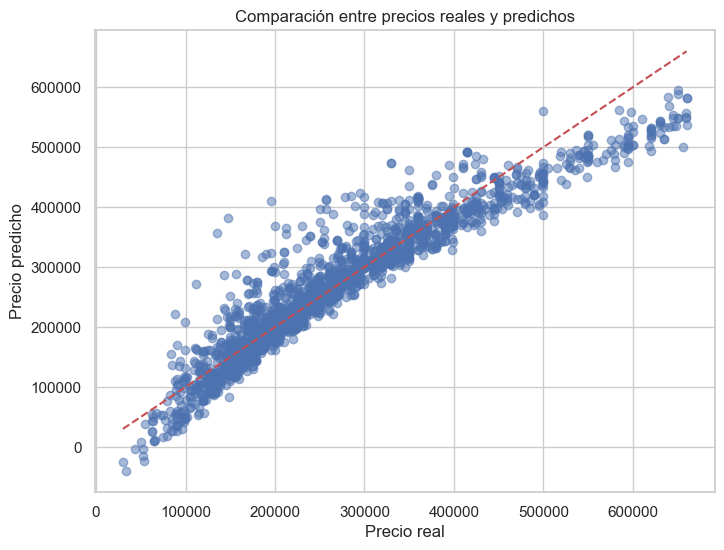

In [40]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Precio real')
plt.ylabel('Precio predicho')
plt.title('Comparación entre precios reales y predichos')
plt.grid(True)
plt.show()


En el gráfico se muestra una nube de puntos que compara los precios reales de las viviendas (eje X) con los precios predichos por el modelo (eje Y). La línea roja discontinua representa la línea ideal donde los precios reales coincidirían exactamente con los predichos.

Si todos los puntos estuvieran sobre la línea roja, significaría que el modelo ha predicho todos los precios de forma perfecta. En este caso, observamos que los puntos están bastante alineados en torno a la línea roja, lo cual indica que el modelo realiza predicciones precisas y consistentes para la mayoría de los casos. La ligera dispersión alrededor de la línea indica que hay cierto margen de error, pero no hay desviaciones graves ni patrones extraños, lo cual refuerza que el modelo es fiable para este problema.

En resumen, la gráfica confirma visualmente lo que ya se observó en las métricas: el modelo de regresión lineal se ajusta bien a los datos y es capaz de predecir los precios de las viviendas con un buen nivel de precisión.